In [1]:
__depends__ = [
    "../../../data/database-results/phase-1/timestamp.txt",
    "../../../data/database-observations/timestamp.txt",
]
__dest__ = ["../../../figures/probabilistic-projections.pdf"]

In [2]:
PROBABILISTIC_PROJECTIONS_FIGURE_PDF = __dest__[0]

In [3]:
%load_ext nb_black

<IPython.core.display.Javascript object>

# Probabilistic projections

In [4]:
import glob
import logging
import os
import re
from distutils.util import strtobool
from pathlib import Path

import numpy as np
import pyam
import tqdm

from pymagicc.io import MAGICCData
from scmdata import df_append, ScmDataFrame

import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf

%matplotlib inline

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [5]:
from utils import (
    clean_label,
    clean_labels,
    convert_scmdf_to_pyamdf_year_only,
    load_database_files,
    prep_str_for_filename,
    reduce_to_one_variant_per_model,
)

<IPython.core.display.Javascript object>

In [6]:
TEST_RUN = strtobool(os.getenv("CI", "False")) or False
TEST_RUN

1

<IPython.core.display.Javascript object>

In [7]:
logger = logging.getLogger()

<IPython.core.display.Javascript object>

In [8]:
color_map_scenarios_base = {
    "ssp119": "AR6-SSP1-1.9",
    "ssp126": "AR6-SSP1-2.6",
    "ssp245": "AR6-SSP2-4.5",
    "ssp370": "AR6-SSP3-7.0",
    "ssp370-lowNTCF": "AR6-SSP3-LowNTCF",
    "ssp370-lowNTCF-gidden": "AR6-SSP3-LowNTCF",
    "ssp370-lowNTCF-aerchemmip": "AR6-SSP3-LowNTCF",
    "ssp434": "AR6-SSP4-3.4",
    "ssp460": "AR6-SSP4-6.0",
    "ssp585": "AR6-SSP5-8.5",
    "ssp534-over": "AR6-SSP5-3.4-OS",
    "historical": "black",
    "rcp26": "AR5-RCP-2.6",
    "rcp45": "AR5-RCP-4.5",
    "rcp60": "AR5-RCP-6.0",
    "rcp85": "AR5-RCP-8.5",
    "historical-cmip5": "tab:gray",
}

color_map_scenarios = {}
for k, v in color_map_scenarios_base.items():
    color_map_scenarios[k] = v
    color_map_scenarios["esm-{}".format(k)] = v
    color_map_scenarios["esm-{}-allGHG".format(k)] = v

pyam.run_control().update({"color": {"scenario": color_map_scenarios}})

<IPython.core.display.Javascript object>

In [9]:
color_map_models = {"Observations (Priestley Centre)": "black"}

pyam.run_control().update({"color": {"climatemodel": color_map_models}})

<IPython.core.display.Javascript object>

## Load data

### Observations

In [10]:
OBS_PATH = os.path.join("..", "..", "..", "data", "database-observations")
OBS_PATH

'../../../data/database-observations'

<IPython.core.display.Javascript object>

In [11]:
db_obs = pyam.concat(glob.glob(os.path.join(OBS_PATH, "*.csv")))
db_obs.timeseries().head()

INFO:root:Reading `../../../data/database-observations/rcmip-observations_observations-priestley-centre_world_surface-air-temperature-change.csv`


1850  \
model       scenario   region variable                       unit climatemodel                                
unspecified historical World  Surface Air Temperature Change K    Observations (Priestley Centre) -0.042412   

                                                                                                       1851  \
model       scenario   region variable                       unit climatemodel                                
unspecified historical World  Surface Air Temperature Change K    Observations (Priestley Centre)  0.123588   

                                                                                                       1852  \
model       scenario   region variable                       unit climatemodel                                
unspecified historical World  Surface Air Temperature Change K    Observations (Priestley Centre)  0.085588   

                                                                                                       1853  \
model       scenario   region variable                       unit climatemodel                                
unspecified historical World  Surface Air Temperature Change K    Observations (Priestley Centre)  0.025588   

                                                                                                       1854  \
model       scenario   region variable                       unit climatemodel                                
unspecified historical World  Surface Air Temperature Change K    Observations (Priestley Centre)  0.086588   

                                                                                                       1855  \
model       scenario   region variable                       unit climatemodel                                
unspecified historical World  Surface Air Temperature Change K    Observations (Priestley Centre)  0.087588   

                                                                                                       1856  \
model       scenario   region variable                       unit climatemodel                                
unspecified historical World  Surface Air Temperature Change K    Observations (Priestley Centre) -0.040412   

                                                                                                       1857  \
model       scenario   region variable                       unit climatemodel                                
unspecified historical World  Surface Air Temperature Change K    Observations (Priestley Centre) -0.138412   

                                                                                                       1858  \
model       scenario   region variable                       unit climatemodel                                
unspecified historical World  Surface Air Temperature Change K    Observations (Priestley Centre) -0.074412   

                                                                                                       1859  \
model       scenario   region variable                       unit climatemodel                                
unspecified historical World  Surface Air Temperature Change K    Observations (Priestley Centre) -0.012412   

                                                                                                   ...  \
model       scenario   region variable                       unit climatemodel                     ...   
unspecified historical World  Surface Air Temperature Change K    Observations (Priestley Centre)  ...   

                                                                                                       2009  \
model       scenario   region variable                       unit climatemodel                                
unspecified historical World  Surface Air Temperature Change K    Observations (Priestley Centre)  0.976085   

                                                                                                       2010  \

<IPython.core.display.Javascript object>

### RCMIP results

In [12]:
RESULTS_PATH = os.path.join("..", "..", "..", "data", "database-results", "phase-1")
RESULTS_PATH

'../../../data/database-results/phase-1'

<IPython.core.display.Javascript object>

In [13]:
model_of_interest = [
    ".*acc2.*",
    ".*cicero-scm.*",
    #     ".*escimo.*",
    ".*fair-1.5.*",
    #     ".*gir.*",
    #     ".*greb.*",
    ".*hector.*",
    #     ".*magicc7.*",
    ".*mce.*",
    ".*oscar.*",
    ".*wasp.*",
]

results_files = list(Path(RESULTS_PATH).rglob("*.csv")) + list(
    Path(RESULTS_PATH).rglob("*.xlsx")
)
results_files = [
    str(p)
    for p in results_files
    if any([bool(re.match(m, str(p))) for m in model_of_interest]) and "$" not in str(p)
]
print("Number of available files: {}".format(len(results_files)))
results_files[:5]

Number of available files: 1140


['../../../data/database-results/phase-1/rcmip-phase-1_mce,v1-1,cmip5-mri-cgcm3-calib_world_net-ocean-to-atmosphere-flux-co2.csv',
 '../../../data/database-results/phase-1/rcmip-phase-1_cicero-scm-ecs3_world_emissions-ch4.csv',
 '../../../data/database-results/phase-1/rcmip-phase-1_cicero-scm_world_radiative-forcing-anthropogenic-f-gases-hfc-hfc134a.csv',
 '../../../data/database-results/phase-1/rcmip-phase-1_mce,v1-1,cmip6-cams-csm1-0-calib_world_net-ocean-to-atmosphere-flux-co2.csv',
 '../../../data/database-results/phase-1/rcmip-phase-1_mce,v1-1,cmip6-canesm5-calib_world_heat-content-ocean.csv']

<IPython.core.display.Javascript object>

In [14]:
variables_of_interest = [
    ".*surface-air-temperature-change.*quantile.*",
    ".*radiative-forcing-\d.*quantile.*",
    ".*radiative-forcing-anthropogenic-aerosols-\d.*quantile.*",
    ".*radiative-forcing-anthropogenic-co2-\d.*quantile.*",
]

relevant_files = [
    str(p)
    for p in results_files
    if any([bool(re.match(v, str(p))) for v in variables_of_interest])
]
print("Number of relevant files: {}".format(len(relevant_files)))
relevant_files[:5]

Number of relevant files: 10


['../../../data/database-results/phase-1/rcmip-phase-1_mce,v1-1,prob_world_effective-radiative-forcing-33th-quantile.csv',
 '../../../data/database-results/phase-1/rcmip-phase-1_mce,v1-1,prob_world_effective-radiative-forcing-50th-quantile.csv',
 '../../../data/database-results/phase-1/rcmip-phase-1_mce,v1-1,prob_world_surface-air-temperature-change-33th-quantile.csv',
 '../../../data/database-results/phase-1/rcmip-phase-1_mce,v1-1,prob_world_surface-air-temperature-change-50th-quantile.csv',
 '../../../data/database-results/phase-1/rcmip-phase-1_mce,v1-1,prob_world_effective-radiative-forcing-83th-quantile.csv']

<IPython.core.display.Javascript object>

In [15]:
logging.getLogger("scmdata").setLevel(logging.WARNING)
db = load_database_files(relevant_files)
logging.getLogger("scmdata").setLevel(logging.INFO)
db.head()

time                                                                                                       1850-01-01 00:00:00  \
model          scenario region variable                                  unit  climatemodel  unit_context                        
not_applicable 1pctCO2  World  Effective Radiative Forcing|17th quantile W/m^2 MCE,v1-1,PROB not_required             0.015707   
                               Effective Radiative Forcing|33th quantile W/m^2 MCE,v1-1,PROB not_required             0.020056   
                               Effective Radiative Forcing|50th quantile W/m^2 MCE,v1-1,PROB not_required             0.022675   
                               Effective Radiative Forcing|67th quantile W/m^2 MCE,v1-1,PROB not_required             0.024717   
                               Effective Radiative Forcing|83th quantile W/m^2 MCE,v1-1,PROB not_required             0.026629   

time                                                                                                       1851-01-01 00:00:00  \
model          scenario region variable                                  unit  climatemodel  unit_context                        
not_applicable 1pctCO2  World  Effective Radiative Forcing|17th quantile W/m^2 MCE,v1-1,PROB not_required             0.047122   
                               Effective Radiative Forcing|33th quantile W/m^2 MCE,v1-1,PROB not_required             0.060169   
                               Effective Radiative Forcing|50th quantile W/m^2 MCE,v1-1,PROB not_required             0.068024   
                               Effective Radiative Forcing|67th quantile W/m^2 MCE,v1-1,PROB not_required             0.074152   
                               Effective Radiative Forcing|83th quantile W/m^2 MCE,v1-1,PROB not_required             0.079888   

time                                                                                                       1852-01-01 00:00:00  \
model          scenario region variable                                  unit  climatemodel  unit_context                        
not_applicable 1pctCO2  World  Effective Radiative Forcing|17th quantile W/m^2 MCE,v1-1,PROB not_required             0.078537   
                               Effective Radiative Forcing|33th quantile W/m^2 MCE,v1-1,PROB not_required             0.100282   
                               Effective Radiative Forcing|50th quantile W/m^2 MCE,v1-1,PROB not_required             0.113373   
                               Effective Radiative Forcing|67th quantile W/m^2 MCE,v1-1,PROB not_required             0.123586   
                               Effective Radiative Forcing|83th quantile W/m^2 MCE,v1-1,PROB not_required             0.133146   

time                                                                                                       1853-01-01 00:00:00  \
model          scenario region variable                                  unit  climatemodel  unit_context                        
not_applicable 1pctCO2  World  Effective Radiative Forcing|17th quantile W/m^2 MCE,v1-1,PROB not_required             0.109952   
                               Effective Radiative Forcing|33th quantile W/m^2 MCE,v1-1,PROB not_required             0.140395   
                               Effective Radiative Forcing|50th quantile W/m^2 MCE,v1-1,PROB not_required             0.158723   
                               Effective Radiative Forcing|67th quantile W/m^2 MCE,v1-1,PROB not_required             0.173021   
                               Effective Radiative Forcing|83th quantile W/m^2 MCE,v1-1,PROB not_required             0.186405   

time                                                                                                       1854-01-01 00:00:00  \
model          scenario region variable                                  unit  climatemodel  unit_context                        
not_applicable 1pctCO2  World  Effective Radiative Forcing|17th quantile W/m^2 MCE,v1-1,PROB not

<IPython.core.display.Javascript object>

### CMIP5 and CMIP6 data

In [16]:
CMIP_PROCESSED_DATA_PATH = os.path.join("..", "..", "..", "data", "cmip-output")
CMIP_PROCESSED_DATA_PATH

'../../../data/cmip-output'

<IPython.core.display.Javascript object>

In [17]:
def load_tas_file(f):
    out = MAGICCData(f)
    metadata = out.metadata
    assert out["variable"].unique().tolist() == ["tas"]
    out.set_meta("Surface Air Temperature Change", "variable")
    try:
        source_id = out.metadata["(child) source_id"]
        variant_id = out.metadata["(child) variant_label"]
        cmip = "CMIP6"
    except KeyError:
        source_id = out.metadata["(child) model_id"]
        variant_id = os.path.basename(f).split("_")[-2]
        cmip = "CMIP5"

    out.set_meta(source_id, "source_id")
    out.set_meta("_".join([source_id, variant_id]), "climatemodel")
    out.set_meta(out.metadata["(child) experiment_id"], "scenario")
    out.set_meta(cmip, "mip_era")

    out = out.timeseries().reset_index().drop(["todo", "climate_model"], axis="columns")

    out = MAGICCData(out)
    out.metadata = metadata

    return out


cmip_files = glob.glob(os.path.join(CMIP_PROCESSED_DATA_PATH, "NORMED*tas*.MAG"))

db_cmip = df_append(
    [load_tas_file(f).filter(region="World") for f in tqdm.tqdm_notebook(cmip_files)]
)
db_cmip.head()

time                                                                                                          1850-07-01  \
model       scenario     region variable                       unit climatemodel         mip_era source_id                 
unspecified 1pctCO2      World  Surface Air Temperature Change K    BCC-CSM2-MR_r1i1p1f1 CMIP6   BCC-CSM2-MR    0.235092   
                                                                    BCC-ESM1_r1i1p1f1    CMIP6   BCC-ESM1      -0.072296   
            1pctCO2-bgc  World  Surface Air Temperature Change K    BCC-CSM2-MR_r1i1p1f1 CMIP6   BCC-CSM2-MR    0.237105   
            1pctCO2-rad  World  Surface Air Temperature Change K    BCC-CSM2-MR_r1i1p1f1 CMIP6   BCC-CSM2-MR    0.300191   
            abrupt-4xCO2 World  Surface Air Temperature Change K    BCC-CSM2-MR_r1i1p1f1 CMIP6   BCC-CSM2-MR    1.179010   

time                                                                                                          1851-07-01  \
model       scenario     region variable                       unit climatemodel         mip_era source_id                 
unspecified 1pctCO2      World  Surface Air Temperature Change K    BCC-CSM2-MR_r1i1p1f1 CMIP6   BCC-CSM2-MR    0.110569   
                                                                    BCC-ESM1_r1i1p1f1    CMIP6   BCC-ESM1      -0.108386   
            1pctCO2-bgc  World  Surface Air Temperature Change K    BCC-CSM2-MR_r1i1p1f1 CMIP6   BCC-CSM2-MR    0.146162   
            1pctCO2-rad  World  Surface Air Temperature Change K    BCC-CSM2-MR_r1i1p1f1 CMIP6   BCC-CSM2-MR    0.271106   
            abrupt-4xCO2 World  Surface Air Temperature Change K    BCC-CSM2-MR_r1i1p1f1 CMIP6   BCC-CSM2-MR    1.769500   

time                                                                                                          1852-07-01  \
model       scenario     region variable                       unit climatemodel         mip_era source_id                 
unspecified 1pctCO2      World  Surface Air Temperature Change K    BCC-CSM2-MR_r1i1p1f1 CMIP6   BCC-CSM2-MR    0.128055   
                                                                    BCC-ESM1_r1i1p1f1    CMIP6   BCC-ESM1      -0.082006   
            1pctCO2-bgc  World  Surface Air Temperature Change K    BCC-CSM2-MR_r1i1p1f1 CMIP6   BCC-CSM2-MR    0.115545   
            1pctCO2-rad  World  Surface Air Temperature Change K    BCC-CSM2-MR_r1i1p1f1 CMIP6   BCC-CSM2-MR    0.288205   
            abrupt-4xCO2 World  Surface Air Temperature Change K    BCC-CSM2-MR_r1i1p1f1 CMIP6   BCC-CSM2-MR    2.204930   

time                                                                                                          1853-07-01  \
model       scenario     region variable                       unit climatemodel         mip_era source_id                 
unspecified 1pctCO2      World  Surface Air Temperature Change K    BCC-CSM2-MR_r1i1p1f1 CMIP6   BCC-CSM2-MR    0.200446   
                                                                    BCC-ESM1_r1i1p1f1    CMIP6   BCC-ESM1      -0.031320   
            1pctCO2-bgc  World  Surface Air Temperature Change K    BCC-CSM2-MR_r1i1p1f1 CMIP6   BCC-CSM2-MR    0.051096   
            1pctCO2-rad  World  Surface Air Temperature Change K    BCC-CSM2-MR_r1i1p1f1 CMIP6   BCC-CSM2-MR    0.314625   
            abrupt-4xCO2 World  Surface Air Temperature Change K    BCC-CSM2-MR_r1i1p1f1 CMIP6   BCC-CSM2-MR    2.333120   

time                                                                                                          1854-07-01  \
model       scenario     region variable                       unit climatemodel         mip_era source_id                 
unspecified 1pctCO2      World  Surface Air Temperature Change K    BCC-CSM2-MR_r1i1p1f1 CMIP6   BCC-CSM2-MR    0.141776   
                                                                    BCC-ESM1_r1i1p1f1    CMIP6   BCC-ESM1      -0.022090   
            1pctCO2-bgc  Wor

<IPython.core.display.Javascript object>

## Get consistent quantiles

In [18]:
db.filter(climatemodel="*OSCAR*")["variable"].unique()

array([], dtype=object)

<IPython.core.display.Javascript object>

In [19]:
db_quantiles = db.timeseries().reset_index()
assert db_quantiles["variable"].apply(lambda x: "quantile" in x).all()
db_quantiles["quantile"] = db_quantiles["variable"].apply(
    lambda x: float(re.findall(".*\|(\S*)th.*", x)[0])
)
assert not db_quantiles["quantile"].isnull().any()
db_quantiles["variable"] = db_quantiles["variable"].apply(
    lambda x: "|".join(x.split("|")[:-1])
)
db_quantiles = ScmDataFrame(db_quantiles).timeseries().stack().unstack("quantile")
db_quantiles = db_quantiles.interpolate(method="index", axis=1)

for c in [0.0, 100.0]:
    if c in db_quantiles:
        db_quantiles = db_quantiles.drop(c, axis="columns")
db_quantiles.head()

quantile                                                                                                      17.0  \
model   scenario region variable                    unit  climatemodel  unit_context time                            
AIM/CGE ssp370   World  Effective Radiative Forcing W/m^2 MCE,v1-1,PROB not_required 1850-01-01 00:00:00  0.239415   
                                                                                     1851-01-01 00:00:00  0.239569   
                                                                                     1852-01-01 00:00:00  0.235221   
                                                                                     1853-01-01 00:00:00  0.061955   
                                                                                     1854-01-01 00:00:00  0.013115   

quantile                                                                                                      33.0  \
model   scenario region variable                    unit  climatemodel  unit_context time                            
AIM/CGE ssp370   World  Effective Radiative Forcing W/m^2 MCE,v1-1,PROB not_required 1850-01-01 00:00:00  0.259055   
                                                                                     1851-01-01 00:00:00  0.259621   
                                                                                     1852-01-01 00:00:00  0.255725   
                                                                                     1853-01-01 00:00:00  0.082867   
                                                                                     1854-01-01 00:00:00  0.034381   

quantile                                                                                                      50.0  \
model   scenario region variable                    unit  climatemodel  unit_context time                            
AIM/CGE ssp370   World  Effective Radiative Forcing W/m^2 MCE,v1-1,PROB not_required 1850-01-01 00:00:00  0.270880   
                                                                                     1851-01-01 00:00:00  0.271694   
                                                                                     1852-01-01 00:00:00  0.268069   
                                                                                     1853-01-01 00:00:00  0.095458   
                                                                                     1854-01-01 00:00:00  0.047184   

quantile                                                                                                      67.0  \
model   scenario region variable                    unit  climatemodel  unit_context time                            
AIM/CGE ssp370   World  Effective Radiative Forcing W/m^2 MCE,v1-1,PROB not_required 1850-01-01 00:00:00  0.280105   
                                                                                     1851-01-01 00:00:00  0.281112   
                                                                                     1852-01-01 00:00:00  0.277700   
                                                                                     1853-01-01 00:00:00  0.105280   
                                                                                     1854-01-01 00:00:00  0.057171   

quantile                                                                                                      83.0  
model   scenario region variable                    unit  climatemodel  unit_context time                           
AIM/CGE ssp370   World  Effective Radiative Forcing W/m^2 MCE,v1-1,PROB not_required 1850-01-01 00:00:00  0.288740  
                                                                                     1851-01-01 00:00:00  0.289928  
                                                                                     1852-01-01 00:00:00  0.286714  
                                                                                     1853-01-01 00:00:00  0

<IPython.core.display.Javascript object>

In [20]:
db_quantiles = ScmDataFrame(db_quantiles.stack().unstack("time"))
db_quantiles.head()

time                                                                                           1850-01-01 00:00:00  \
model   scenario region variable                    unit  climatemodel  quantile unit_context                        
AIM/CGE ssp370   World  Effective Radiative Forcing W/m^2 MCE,v1-1,PROB 17.0     not_required             0.239415   
                                                                        33.0     not_required             0.259055   
                                                                        50.0     not_required             0.270880   
                                                                        67.0     not_required             0.280105   
                                                                        83.0     not_required             0.288740   

time                                                                                           1851-01-01 00:00:00  \
model   scenario region variable                    unit  climatemodel  quantile unit_context                        
AIM/CGE ssp370   World  Effective Radiative Forcing W/m^2 MCE,v1-1,PROB 17.0     not_required             0.239569   
                                                                        33.0     not_required             0.259621   
                                                                        50.0     not_required             0.271694   
                                                                        67.0     not_required             0.281112   
                                                                        83.0     not_required             0.289928   

time                                                                                           1852-01-01 00:00:00  \
model   scenario region variable                    unit  climatemodel  quantile unit_context                        
AIM/CGE ssp370   World  Effective Radiative Forcing W/m^2 MCE,v1-1,PROB 17.0     not_required             0.235221   
                                                                        33.0     not_required             0.255725   
                                                                        50.0     not_required             0.268069   
                                                                        67.0     not_required             0.277700   
                                                                        83.0     not_required             0.286714   

time                                                                                           1853-01-01 00:00:00  \
model   scenario region variable                    unit  climatemodel  quantile unit_context                        
AIM/CGE ssp370   World  Effective Radiative Forcing W/m^2 MCE,v1-1,PROB 17.0     not_required             0.061955   
                                                                        33.0     not_required             0.082867   
                                                                        50.0     not_required             0.095458   
                                                                        67.0     not_required             0.105280   
                                                                        83.0     not_required             0.114474   

time                                                                                           1854-01-01 00:00:00  \
model   scenario region variable                    unit  climatemodel  quantile unit_context                        
AIM/CGE ssp370   World  Effective Radiative Forcing W/m^2 MCE,v1-1,PROB 17.0     not_required             0.013115   
                                                                        33.0     not_required             0.034381   
                                                                        50.0     not_required             0.047184   
                                                                        67.0     not_required         

<IPython.core.display.Javascript object>

## Plot

In [21]:
sorted(db_quantiles["quantile"].unique())

[17.0, 33.0, 50.0, 67.0, 83.0]

<IPython.core.display.Javascript object>

In [22]:
db_quantiles["climatemodel"].unique()

array(['MCE,v1-1,PROB'], dtype=object)

<IPython.core.display.Javascript object>

In [23]:
db_quantiles.filter(climatemodel="*hector*")["quantile"].unique()

array([], dtype=float64)

<IPython.core.display.Javascript object>

In [24]:
db_quantiles.filter(climatemodel="*OSCAR*", variable="Effective Radiative Forcing*")[
    "scenario"
].unique()

array([], dtype=object)

<IPython.core.display.Javascript object>

In [25]:
matplotlib.rcParams["figure.figsize"] = (6, 4)
matplotlib.rcParams["font.size"] = 6

<IPython.core.display.Javascript object>

no Surface Air Temperature Change data for FaIR-1.5-ENS
no Surface Air Temperature Change data for hector|62381e71|HISTCALIB
no Surface Air Temperature Change data for OSCARv3.0
no Surface Air Temperature Change data for WASP,2,PROB-hist


no Surface Air Temperature Change data for FaIR-1.5-ENS
no Surface Air Temperature Change data for hector|62381e71|HISTCALIB
no Surface Air Temperature Change data for OSCARv3.0
no Surface Air Temperature Change data for WASP,2,PROB-hist


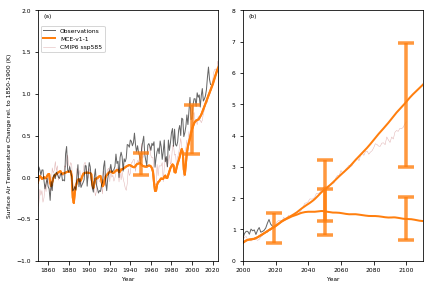

<IPython.core.display.Javascript object>

In [26]:
if TEST_RUN:
    plot_dbs = [db_quantiles.filter(variable="Surface Air Temperature Change")]
else:
    plot_dbs = [
        db_quantiles.filter(variable="Surface Air Temperature Change"),
        db_quantiles.filter(variable="Effective Radiative Forcing").append(
            db_quantiles.filter(
                climatemodel="*hector*", variable="Radiative Forcing"
            )  # hector only reports Radiative Forcing...
        ),
        db_quantiles.filter(
            variable="Effective Radiative Forcing|Anthropogenic|Aerosols"
        ).append(
            db_quantiles.filter(
                climatemodel="*hector*",
                variable="Radiative Forcing|Anthropogenic|Aerosols",
            )  # hector only reports Radiative Forcing...
        ),
        db_quantiles.filter(
            variable="Effective Radiative Forcing|Anthropogenic|CO2"
        ).append(
            db_quantiles.filter(
                climatemodel="*hector*", variable="Radiative Forcing|Anthropogenic|CO2"
            )  # hector only reports Radiative Forcing...
        ),
    ]

var_labels = [
    "Surface Air Temperature Change",
    "Effective Radiative Forcing",
    "Aerosols Effective Radiative Forcing",
    "CO$_2$ Effective Radiative Forcing",
]
ylims = [[-1, 2.0], [-3, 4.0], [-1.5, 0.2], [0, 3]]
ylim_insets = [[0, 8], [0, 14], [-2, 0], [0, 10]]
# bounds are inclusive
reference_periods = [(1850, 1900), None, None, None]
legend_kwargs_list = [
    {"loc": "upper left", "bbox_to_anchor": (0, 0.5, 0.5, 0.45)},
    {"loc": "upper left", "bbox_to_anchor": (0, 0.5, 0.5, 0.45)},
    {"loc": "upper right", "bbox_to_anchor": (0, 0.5, 1.0, 0.5)},
    {"loc": "upper left", "bbox_to_anchor": (0, 0.5, 0.5, 0.45)},
]
plot_scenarios = ["ssp119", "ssp585"]
plot_climatemodels_colours = {
    "FaIR-1.5-ENS": "tab:purple",
    "hector|62381e71|HISTCALIB": "tab:green",
    "OSCARv3.0": "tab:olive",
    "WASP,2,PROB-hist": "tab:blue",
    "MCE,v1-1,PROB": "tab:orange",
}
plot_region = "World"

broken_cmip5_climatemodel = [
    "HadGEM2-CC_r1i1p1",
    "HadGEM2-CC_r2i1p1",
    "HadGEM2-CC_r3i1p1",
]

mid_quantile = 50.0
lower_quantile = 17.0
upper_quantile = 83.0
# lower_quantile = 33.0
# upper_quantile = 67.0
# lower_quantile = 16.0l
year_quantile_base = np.array([1950, 2000])  # , 2200, 2300])
year_quantile_inset = np.array([2019, 2050, 2100])  # , 2200, 2300])

xlim = [1850, 2025]
xlim_inset = [2000, 2110]

for plot_db, var_label, ylim, ylim_inset, reference_period, legend_kwargs in zip(
    plot_dbs, var_labels, ylims, ylim_insets, reference_periods, legend_kwargs_list
):
    fig, (ax_base, ax_inset) = plt.subplots(nrows=1, ncols=2)

    for ax, year_quantile in zip(
        [ax_base, ax_inset], [year_quantile_base, year_quantile_inset]
    ):
        bar_year_shift = 0
        plt.sca(ax)
        for plot_climatemodel, colour in plot_climatemodels_colours.items():
            mdf = plot_db.filter(
                scenario=plot_scenarios,
                climatemodel=plot_climatemodel,
                region=plot_region,
            )
            if mdf.timeseries().empty:
                print("no {} data for {}".format(var_label, plot_climatemodel))
                continue

            if reference_period is not None:
                pdf = convert_scmdf_to_pyamdf_year_only(
                    ScmDataFrame(
                        mdf.filter(quantile=mid_quantile).relative_to_ref_period_mean(
                            year=range(reference_period[0], reference_period[1] + 1)
                        )
                    )
                )
                ref_period_offset = (
                    mdf.filter(
                        quantile=mid_quantile,
                        year=range(reference_period[0], reference_period[1] + 1),
                    )
                    .timeseries()
                    .mean(axis=1)
                    .values[0]
                )
            else:
                pdf = convert_scmdf_to_pyamdf_year_only(
                    ScmDataFrame(mdf.filter(quantile=mid_quantile))
                )
                ref_period_offset = 0

            pdf.line_plot(ax=ax, color=colour, linewidth=2, label=plot_climatemodel)

            quantile_vals = {k: {} for k in plot_scenarios}
            for scenario in quantile_vals.keys():
                mid_quantiles = year_quantile * np.nan
                upper_quantiles = year_quantile * np.nan
                lower_quantiles = year_quantile * np.nan
                for i, y in enumerate(year_quantile):
                    bdf = mdf.filter(scenario=scenario, year=int(y))
                    mid_quantiles[i] = (
                        bdf.filter(quantile=mid_quantile).values - ref_period_offset
                    )
                    lower_quantiles[i] = (
                        bdf.filter(quantile=lower_quantile).values - ref_period_offset
                    )
                    upper_quantiles[i] = (
                        bdf.filter(quantile=upper_quantile).values - ref_period_offset
                    )

                quantile_vals[scenario]["years"] = year_quantile
                quantile_vals[scenario]["middles"] = mid_quantiles
                quantile_vals[scenario]["upper"] = upper_quantiles
                quantile_vals[scenario]["lower"] = lower_quantiles

            errorbar_kwargs = {
                "color": colour,
                "capsize": 8,
                "capthick": 3.5,
                "elinewidth": 3.5,
                "linewidth": 0,
                "zorder": 5,
                "alpha": 0.8,
            }
            plt.errorbar(
                quantile_vals["ssp119"]["years"] + bar_year_shift,
                quantile_vals["ssp119"]["middles"],
                np.vstack(
                    [
                        quantile_vals["ssp119"]["middles"]
                        - quantile_vals["ssp119"]["lower"],
                        quantile_vals["ssp119"]["upper"]
                        - quantile_vals["ssp119"]["middles"],
                    ]
                ),
                **errorbar_kwargs
            )

            scen_idxs = np.where(year_quantile > 2020)
            if scen_idxs[0].size > 0:
                plt.errorbar(
                    quantile_vals["ssp585"]["years"][scen_idxs] + bar_year_shift,
                    quantile_vals["ssp585"]["middles"][scen_idxs],
                    np.vstack(
                        [
                            quantile_vals["ssp585"]["middles"][scen_idxs]
                            - quantile_vals["ssp585"]["lower"][scen_idxs],
                            quantile_vals["ssp585"]["upper"][scen_idxs]
                            - quantile_vals["ssp585"]["middles"][scen_idxs],
                        ]
                    ),
                    **errorbar_kwargs
                )

            bar_year_shift = (
                -bar_year_shift if bar_year_shift > 0 else -bar_year_shift + 3
            )

        obs_df = db_obs.filter(
            variable="{}*".format(var_label), region=plot_region, scenario="historical"
        )
        if not obs_df.data.empty:
            if reference_period is None:
                raise NotImplementedError
            convert_scmdf_to_pyamdf_year_only(
                ScmDataFrame(
                    ScmDataFrame(obs_df).relative_to_ref_period_mean(
                        year=range(reference_period[0], reference_period[1] + 1)
                    )
                )
            ).line_plot(
                color="climatemodel", linewidth=1, legend=True, ax=ax, alpha=0.6
            )

        cmip_df = db_cmip.filter(
            variable="{}*".format(var_label),
            region=plot_region,
            scenario=plot_scenarios,
        )

        if not cmip_df.timeseries().empty:
            if reference_period is None:
                raise NotImplementedError
            reduce_to_one_variant_per_model(
                convert_scmdf_to_pyamdf_year_only(
                    ScmDataFrame(
                        cmip_df.filter(
                            climatemodel=broken_cmip5_climatemodel, keep=False
                        ).relative_to_ref_period_mean(
                            year=range(reference_period[0], reference_period[1] + 1)
                        )
                    )
                )
            ).line_plot(
                linewidth=0.5,
                alpha=0.3,
                legend=False,
                zorder=1,
                color="scenario",
                ax=ax,
            )

    handles_raw, labels_raw = ax_base.get_legend_handles_labels()
    handles = []
    labels = []
    for lr, hr in sorted(zip(labels_raw, handles_raw), key=lambda t: t[0]):
        if lr.startswith("ssp"):
            lr = "CMIP6 {}".format(lr)

        if lr.startswith("Observations"):
            lr = clean_label(lr)
            handles.insert(0, hr)
            labels.insert(0, lr)
            hr.set_zorder(3)
            continue

        if not lr.startswith("CMIP"):
            lr = clean_label(lr)

        if lr in labels:
            continue

        labels.append(lr)
        handles.append(hr)

    ax_base.legend(handles, labels, **legend_kwargs)
    ax_base.annotate("(a)", (0.03, 0.97), xycoords="axes fraction")

    ax_inset.annotate("(b)", (0.03, 0.97), xycoords="axes fraction")
    ax_inset.get_legend().remove()
    ax_inset.set_title("")
    ax_inset.set_xlim(xlim_inset)
    ax_inset.set_ylim(ylim_inset)
    ax_inset.set_xlabel("Year")
    ax_inset.set_ylabel("")

    ax_base.set_title("")
    ax_base.set_xlim(xlim)
    ax_base.set_ylim(ylim)

    base_label = "{} ({})".format(
        var_label, plot_db.get_unique_meta("unit", no_duplicates=True)
    )
    if reference_period is not None:
        ylabel = base_label.replace(
            var_label,
            "{} rel. to {}-{}".format(
                var_label, reference_period[0], reference_period[1]
            ),
        )
    else:
        ylabel = base_label

    ax_base.set_ylabel(ylabel)

    plt.tight_layout()
    plt.show()
    fig.savefig(
        PROBABILISTIC_PROJECTIONS_FIGURE_PDF.replace(
            ".pdf",
            "-{}.pdf".format(var_label.lower().replace(" ", "-")).replace("$", ""),
        )
    )
#     break

These plots won't go in the paper but they might be helpful in other work.

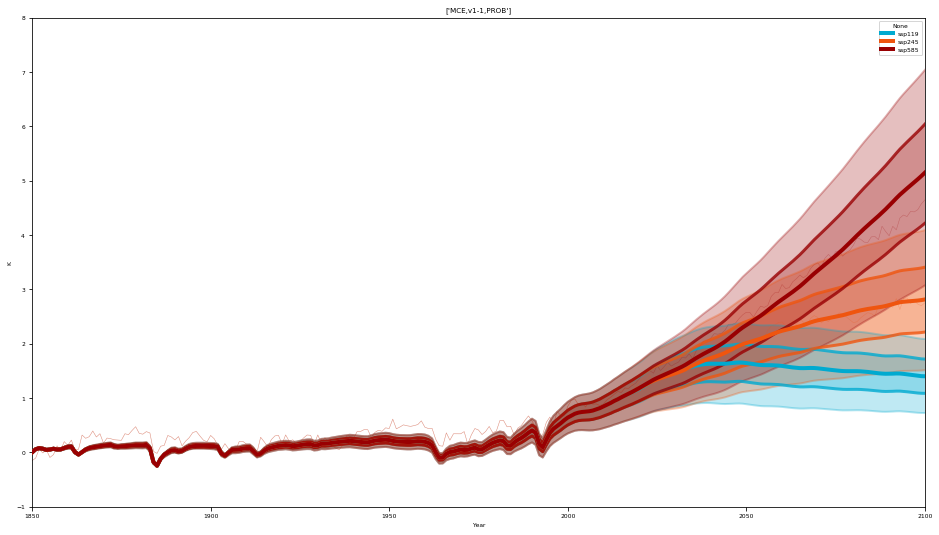

<IPython.core.display.Javascript object>

In [27]:
plot_variable = "Surface Air Temperature Change"
plot_quantiles = [5.0, 95.0]
plot_scenarios = ["ssp119", "ssp245", "ssp585"]

if TEST_RUN:
    plot_climatemodels = [["MCE,v1-1,PROB"]]
else:
    plot_climatemodels = [
        ["FaIR-1.5-ENS"],
        ["OSCARv3.0"],
        ["hector|62381e71|HISTCALIB"],
        ["WASP,2,PROB-hist"],
        ["MCE,v1-1,PROB"],
    ]

plot_region = "World"

broken_cmip5_climatemodel = [
    "HadGEM2-CC_r1i1p1",
    "HadGEM2-CC_r2i1p1",
    "HadGEM2-CC_r3i1p1",
]

xlim = [1850, 2100]
ylim = [-1, 8]

if TEST_RUN:
    plot_quantiles_alpha_lw_zorder = (
        ([50.0, 50.0], 1, 4, 4),
        ([33.0, 67.0], 0.8, 3, 3.5),
        ([17.0, 83.0], 0.3, 2, 3),
    )
else:
    plot_quantiles_alpha_lw_zorder = (
        ([50.0, 50.0], 1, 4, 4),
        ([33.0, 67.0], 0.8, 3, 3.5),
        ([17.0, 83.0], 0.3, 2, 3),
        ([5.0, 95.0], 0.1, 1, 2),
    )

for plot_climatemodel in plot_climatemodels:
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))
    for plot_quantiles, alpha, linewidth, zorder in plot_quantiles_alpha_lw_zorder:
        pdf = convert_scmdf_to_pyamdf_year_only(
            db_quantiles.filter(
                variable=plot_variable,
                quantile=plot_quantiles,
                scenario=plot_scenarios,
                climatemodel=plot_climatemodel,
                region=plot_region,
            )
        )
        pdf.line_plot(
            ax=ax,
            color="scenario",
            fill_between=True,
            linewidth=linewidth,
            alpha=alpha,
            zorder=zorder,
            #         final_ranges=dict(linewidth=linewidth),
        )

    reduce_to_one_variant_per_model(
        convert_scmdf_to_pyamdf_year_only(
            db_cmip.filter(
                variable=plot_variable,
                region=plot_region,
                scenario=plot_scenarios,
                #             year=years_to_plot,
            ).filter(climatemodel=broken_cmip5_climatemodel, keep=False)
        )
    ).line_plot(
        linewidth=0.5, alpha=0.3, legend=False, zorder=1, color="scenario", ax=ax
    )

    ax.set_title(plot_climatemodel)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    plt.show()
    # ax.set_ylim([-1, 1])